<a href="https://colab.research.google.com/github/Baze-Bai/XAI/blob/HW4/HW4_note%20/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Explainable Deep Learning
### Zejun(Baze) Bai

# What I do
In this report, I use deep learning to develop a model to predict whether patients have cancer according to the sliced image.

# My hypothesis
H0 (NULL Hypothesis): The neural network model does not demonstrate a significant difference in its ability to learn and attribute importance to specific tissue structures(eg., nuclei, cytoplasm, lacuna) in the given histological image.

H1 (Alternative Hypothesis): The neural network model demonstrates a significant difference in its ability to learn and attribute importance to specific tissue structures (e.g., nuclei, cytoplasm, lacuna), with higher attribution focused on certain regions compared to others.

# Run the below Cell first

In [31]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data


# Clone the specific branch (HW1) of the GitHub repository to colab workspace
repo_name = "XAI"  # Change to your repo name
git_path = 'https://github.com/Baze-Bai/XAI.git'  # Root repository path
branch_name = "HW4"  # Replace with your branch name
!git clone --branch "{branch_name}" --single-branch "{git_path}" "{repo_name}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'HW4_note'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'XAI'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 57 (delta 14), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 4.13 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/XAI/HW4_note/XAI/HW4_note/XAI/HW4_note
Explainable_Deep_Learning.ipynb  original_image.jpg


# Install required packages

In [32]:
!pip install tensorflow boto3 python-dotenv


# Import required packages

In [34]:
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries, slic
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
import io
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
import numpy as np
import boto3
from io import BytesIO
from google.colab import userdata
from PIL import Image

In [58]:
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY')
aws_secret_access_key = os.getenv('AWS_SECRET_KEY')
bucket_name = os.getenv('BUCKET_NAME')
model_key = os.getenv('MODEL_KEY')

# Download the model from S3 to local environment

In [59]:
aws_region = "us-east-1"

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=aws_region
)

local_path = "final_hybrid_model.h5"
s3.download_file(bucket_name, model_key, local_path)


# Define the structure of deep learning model and load the local model

In [60]:
# --------------------------------------------------------------------------------
# Squeeze-and-Excitation (SE) block
# --------------------------------------------------------------------------------
def squeeze_excitation_block(input_tensor, reduction_ratio=16):
    channel_dim = int(input_tensor.shape[-1])
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channel_dim // reduction_ratio, activation='relu')(se)
    se = layers.Dense(channel_dim, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channel_dim))(se)
    return layers.Multiply()([input_tensor, se])

# --------------------------------------------------------------------------------
# Depthwise-Separable convolution utility
# --------------------------------------------------------------------------------
def depthwise_separable_conv(x, filters, kernel_size, strides=(1, 1), padding='same'):
    x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# --------------------------------------------------------------------------------
# Pretrained EfficientNetV2B0 Bottleneck
# --------------------------------------------------------------------------------
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    for layer in backbone.layers:
        layer.trainable = False
    x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    return x

# --------------------------------------------------------------------------------
# Neck Section
# --------------------------------------------------------------------------------
def neck_section(inputs):
    x = depthwise_separable_conv(inputs, filters=256, kernel_size=7, strides=(2, 2), padding='same')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = squeeze_excitation_block(x)
    x = layers.Flatten()(x)
    return x

# --------------------------------------------------------------------------------
# Vision Transform (patch-based) branch
# --------------------------------------------------------------------------------
def vision_transform(inputs, patch_size):
    x = layers.Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = layers.Lambda(lambda image: K.cast(image, 'float32') / 255.0)(x)
    x = depthwise_separable_conv(x, 64, kernel_size=3)
    x = depthwise_separable_conv(x, 64, kernel_size=3)
    x = layers.MaxPooling2D((2, 2))(x)
    x = depthwise_separable_conv(x, 128, kernel_size=3)
    x = depthwise_separable_conv(x, 128, kernel_size=3)
    x = layers.MaxPooling2D((2, 2))(x)
    x = squeeze_excitation_block(x)
    x = layers.Flatten()(x)
    return x

# --------------------------------------------------------------------------------
# Adaptive Branch Fusion
# --------------------------------------------------------------------------------
def adaptive_branch_fusion(*branches, hidden_dim=128):
    weighted_branches = []
    for branch in branches:
        gate = layers.Dense(hidden_dim, activation='relu')(branch)
        gate = layers.Dense(1, activation='sigmoid')(gate)
        weighted = layers.Multiply()([branch, gate])
        weighted_branches.append(weighted)
    return layers.Concatenate()(weighted_branches)

# --------------------------------------------------------------------------------
# Build the Full Hybrid Model
# --------------------------------------------------------------------------------
def build_hybrid_model(input_shape, num_classes, patch_size):
    inputs = layers.Input(shape=input_shape)
    efficientnet_features = bottleneck0(inputs)
    patches_features = vision_transform(inputs, patch_size)
    neck_features = neck_section(inputs)
    fused = adaptive_branch_fusion(efficientnet_features, patches_features, neck_features, hidden_dim=64)
    outputs = layers.Dense(num_classes, activation='softmax')(fused)
    return models.Model(inputs=inputs, outputs=outputs)


# Define the specific structure
dl_model = build_hybrid_model(
    input_shape=(128, 128, 3),
    num_classes=2,
    patch_size=(32, 32)
)

# Load the local model
dl_model_path = local_path
dl_model.load_weights(dl_model_path)

I define a hybrid model combining CNN and Vision Transformer features for image classification. It uses a pretrained EfficientNetV2B0 bottleneck for global features, a Vision Transformer-inspired branch for patch-based processing, and a Neck Section for hierarchical feature extraction. Key components include Squeeze-and-Excitation blocks for channel-wise attention, Depthwise-Separable Convolutions for efficiency, and Adaptive Branch Fusion, which learns to weight and combine features from all branches. The final output is a softmax activation for classification.

# Explainable functions

In [61]:
def df_preprocess(image, img_size=(128, 128)):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0

    return np.expand_dims(img, axis=0)

def DL_classify(image, model):
    img = df_preprocess(image)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    return "Malignant (Yes)" if predicted_class == 1 else "Benign (No)"

def normalize_map(heatmap):
    """Normalize a heatmap to the [0,1] range."""
    heatmap -= heatmap.min()
    denom = (heatmap.max() - heatmap.min()) + 1e-8
    heatmap /= denom
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.5, cmap='jet'):
    """
    Overlay `heatmap` on `img`.
    """
    colormap = plt.cm.get_cmap(cmap)
    colored_heatmap = colormap(heatmap)[..., :3]
    overlay = (1 - alpha) * img + alpha * colored_heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay

def integrated_gradients(model, x, baseline=None, steps=50, class_idx=0):
    """
    Computes Integrated Gradients
    """
    x = tf.cast(x, tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(x)
    else:
        baseline = tf.cast(baseline, tf.float32)

    B, H, W, C = x.shape

    alphas = tf.reshape(tf.linspace(0.0, 1.0, steps+1), [steps+1, 1, 1, 1, 1])
    x_expanded = tf.expand_dims(x, axis=0)
    baseline_expanded = tf.expand_dims(baseline, axis=0)
    interpolated = baseline_expanded + alphas * (x_expanded - baseline_expanded)

    with tf.GradientTape() as tape:
        interpolated_reshaped = tf.reshape(interpolated, [(steps+1)*B, H, W, C])
        tape.watch(interpolated_reshaped)
        preds = model(interpolated_reshaped)
        preds_for_class = preds[:, class_idx]
        loss = tf.reduce_sum(preds_for_class)

    grads = tape.gradient(loss, interpolated_reshaped)
    if grads is None:
        raise ValueError("Gradient is None. Not differentiable.")

    grads_reshaped = tf.reshape(grads, [steps+1, B, H, W, C])
    avg_grads = tf.reduce_mean(grads_reshaped[1:], axis=0)
    ig = (x - baseline) * avg_grads
    return ig.numpy()


def DL_explainability(model, image, class_idx=1):
    img_batch = df_preprocess(image)
    ig_map = integrated_gradients(model, img_batch, class_idx=class_idx)

    original_img = img_batch[0]
    normalized_img = (original_img - original_img.min()) / (original_img.max() - original_img.min() + 1e-8)

    ig_map_single = ig_map[0]
    ig_map_2d = np.mean(ig_map_single, axis=-1)
    ig_map_norm = normalize_map(ig_map_2d)
    overlay_img = overlay_heatmap(normalized_img, ig_map_norm, alpha=0.5, cmap='jet')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(normalized_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # IG heatmap
    im = axes[1].imshow(ig_map_norm, cmap="jet")
    axes[1].set_title("IG Map (2D Mean)")
    plt.colorbar(im, ax=axes[1])
    axes[1].axis("off")

    # Overlay images
    axes[2].imshow(overlay_img)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Display the image
    plt.show()


I implement Integrated Gradients (IG) to highlight important input features for model predictions. It preprocesses the image, performs classification, and computes IG by interpolating between a baseline and the input. I define the baseline as 0. The resulting gradients are averaged and visualized as a heatmap. The heatmap is normalized and overlaid on the original image to provide intuitive insights into the model's decision-making.

# Generate the explainability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: Malignant (Yes)


<ipython-input-26-64e13e66d8a7>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


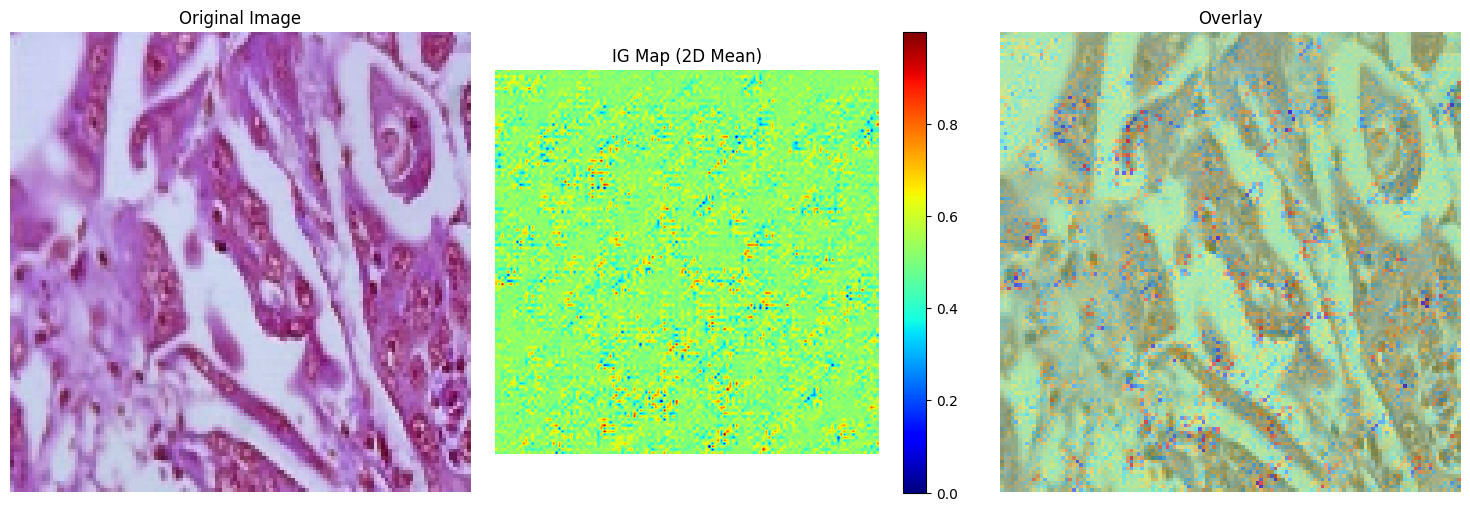

In [ ]:
image = Image.open("original_image.jpg")
image = np.array(image)
# Classification Prediction
prediction = DL_classify(image, dl_model)

print("Prediction:", prediction)

# Explainability
DL_explainability(dl_model, image)

From the output images we can see the red pixels centering on the nuclei and cytoplasm, which are darker color. In the latent color part, which represents lacuna, we can see there are barely red pixels. Most of the pixels in lant color part are between yellow and blue.

# Conclusion And Summary

From the IG image we can see that the pixels of nuclei and cytoplasm (especially nuclei) make an important contribution to the prediction. So we can reject the NULL Hypothesis and accept the Alternative Hypothesis. Since the deep learning model demonstrates a significant difference in its ability to learn and attribute importance to specific tissue structures, focusing more on nuclei and cytoplasm.